# Data importation

In [1]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import networkx as nx
import re

%matplotlib inline

In [2]:
info = pd.read_csv(
    "node_information.csv", 
    header= None, 
    names=["Id", "year", "title", "authors", "journal", "abstract"],
    sep=",",
    index_col = 0
)

In [3]:
X_train = pd.read_csv("training_set.txt", sep=" ", header=None)
X_test = pd.read_csv("testing_set.txt", sep=" ", header=None)
y_train = X_train[2]
X_train.drop([2], axis = 1, inplace = True)

print info.shape, X_train.shape, X_test.shape

(27770, 5) (615512, 2) (32648, 2)


In [4]:
######################
### FOR VALIDATION ###
######################


#####################
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
#####################

#####################
small_portion_to_train = 50000
small_portion_to_test  = 5000
#X_train = X_train[:small_portion_to_train]
#y_train = y_train[:small_portion_to_train]

#X_test  = X_test[:small_portion_to_test]
#y_test = y_test[:small_portion_to_test]
#####################

# Feature Preprocess

- list_authors is the list of authors in the papers
- list_universities is the list where the authors are from

In [5]:
def universities_to_keep(authors, universities):
    while('(' in authors and ')' in authors):
        universities.append( authors[authors.find('(')+1 : authors.find(')')] )
        authors = authors[: authors.find('(')] + authors[ authors.find(')')+1 : ]
            
    if '(' in authors:
        universities.append( authors[authors.find('(')+1 : ])
        authors = authors[: authors.find('(')]
    
    return authors, universities


def name_to_keep(author):
    if len(author.split(' ')) <= 1:
        return author
    
    while( author[0] == ' ' and len(author) > 0):
        author = author[1:]
    while( author[-1] == ' ' and len(author) > 0):
        author = author[:-1]
    
    author = author.replace('.', '. ')
    author = author.replace('.  ', '. ')
    name_to_keep = author.split(' ')[0][0] + '. ' + author.split(' ')[-1]

    return name_to_keep

# Transform concatenated names of authors to a list of authors 
list_authors = []
list_universities = []

info['authors'] = info['authors'].replace(np.nan, 'missing')
for authors in info['authors']:
    if authors != 'missing':
        ### split the different authors
        authors = authors.lower()
        
        ### Find the universities included in the name
        universities = []
        authors, universities = universities_to_keep(authors, universities)
        
        ### Split the authors
        authors = re.split(',|&', authors)
        
        ### For each author, check if university, and store it. Also, keep just the names (To be improved)
        authors_in_article = []      
        for author in authors:
            if author != ' ':
                authors_in_article.append(name_to_keep(author))
            
        list_universities.append(universities)
        list_authors.append(authors_in_article)
    else:
        list_universities.append(['missing'])
        list_authors.append(['missing'])   
        
info['authors'] = list_authors
info['universities'] = list_universities

# Topologic features

In [6]:
def make_graph(X_train, y_train, X_test):
    X_train = pd.concat([X_train, y_train], axis = 1)
    X_train = X_train.values
    G = nx.DiGraph()
    for i in range(X_train.shape[0]):
        source = X_train[i,0]
        target = X_train[i,1]
        G.add_node(source)
        G.add_node(target)
        if X_train[i,2] == 1:
            G.add_edge(source,target)
            
    X_test = X_test.values
    for i in range(X_test.shape[0]):
        source = X_test[i,0]
        target = X_test[i,1]
        G.add_node(source)
        G.add_node(target)
        
    return G  

In [7]:
G = make_graph(X_train, y_train, X_test)  

In [8]:
%%time
from create_topologic_features import create_topologic_features
X_train = create_topologic_features(X_train, G)
X_test = create_topologic_features(X_test, G)

CPU times: user 1min 25s, sys: 804 ms, total: 1min 26s
Wall time: 1min 26s


# Semantic features
- Cosine similarity within the titles as tf-idf
- Cosine similarity within the abstracts as tf-idf
- Cosine similarity within the titles as word2vec
- Cosine similarity within the abstracts as word2vec

### To try
- Difference cosine similarities?
- Keep the stopwords or not?
- Stemmise the words of not?

In [9]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

def text_to_wordlist(text, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    text = BeautifulSoup(text).get_text()
    #  
    # 2. Remove non-letters
    text = re.sub("[\W]"," ", text)
    #
    # 3. Convert words to lower case and split them
    words = text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

# Download the punkt tokenizer for sentence splitting
import nltk.data
nltk.download("punkt")   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def text_to_sentences(text, tokenizer, remove_stopwords=False ):
    # Function to split a text into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(text.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(text_to_wordlist(raw_sentence, remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

train = False
sentences = []  # Initialize an empty list of sentences
word_list_abstract=pd.Series(index=info.index,dtype=np.str)
word_list_title=pd.Series(index=info.index,dtype=np.str)
print "Parsing sentences from training set"
for idx in info.index:
    w_list_a = text_to_sentences(info.loc[idx,"abstract"], tokenizer, True)
    sentences += w_list_a
    word_list_abstract[idx]= w_list_a
    w_list_t = text_to_sentences(info.loc[idx,"title"], tokenizer, True)
    sentences += w_list_t
    word_list_title[idx]= w_list_t

from gensim.models import word2vec
from gensim.models import Word2Vec
num_features = 200    # Word vector dimensionality  
if train:
    # Import the built-in logging module and configure it so that Word2Vec 
    # creates nice output messages
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    # Set values for various parameters
                    
    min_word_count = 10   # Minimum word count                        
    num_workers = 4       # Number of threads to run in parallel
    context = 10          # Context window size                                                                                    
    downsampling = 1e-3   # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)

    print "Training model..."
    model = word2vec.Word2Vec(
        sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling
    )

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model_name = "200features_10minwords_10context"
    model.save(model_name)
else:
    model = Word2Vec.load("200features_10minwords_10context")

def makeFeatureVec(list_of_words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in list_of_words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(text_list, model, num_features):
    # Given a set of texts (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0.
    # 
    # Preallocate a 2D numpy array, for speed
    textFeatureVecs = np.zeros((len(text_list),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for list_of_words in text_list:
        # Print a status message every 1000th review
        """
        if counter%1000. == 0.:
            print "Review %d of %d" % (counter, len(text_list))
        """
        # Call the function (defined above) that makes average feature vectors
        textFeatureVecs[counter] = makeFeatureVec(list_of_words, model, num_features)

        # Increment the counter
        counter = counter + 1.
    return textFeatureVecs

centroid_title = dict(zip(info.index, getAvgFeatureVecs(info.title.values, model, num_features)))
centroid_abstract = dict(zip(info.index, getAvgFeatureVecs(info.abstract.values, model, num_features)))

from sklearn.cluster import KMeans
import time

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.syn0
num_clusters = word_vectors.shape[0] / 5

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print "Time taken for K Means clustering: ", elapsed, "seconds."

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

# Pre-allocate an array for the training set bags of centroids (for speed)
bag_centroids_abstract = {}
#centroids_title = {}
# Transform the training set reviews into bags of centroids
for review, idx in zip(word_list_abstract, word_list_abstract.index):
    bag_centroids_abstract[idx] = create_bag_of_centroids(review[0], word_centroid_map)
#for review, idx in zip(word_list_title, word_list_title.index):
#    centroids_title[idx] = create_bag_of_centroids( review[0], word_centroid_map )

from scipy.spatial.distance import cosine
def compute_cosines(centroids_dic, X):
    bag=[cosine(centroids_dic[x[0]], centroids_dic[x[1]]) for x in X]
    return np.array(bag)

def create_nlp_features(X, centroid_title, centroid_abstract, bag_centroids_abstract):
    X_ = X.copy()
    X = X.values
    
    X_['CosineD_title_centroid'] = compute_cosines(centroid_title,X)
    X_['CosineD_abstract_centroid'] = compute_cosines(centroid_abstract,X)
    X_['CosineD_abstract_bag_centroids'] = compute_cosines(bag_centroids_abstract,X)
    
    return X_


[nltk_data] Downloading package punkt to /home/bat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Parsing sentences from training set

/home/bat/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/home/bat/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:146: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



Time taken for K Means clustering:  59.4925282001 seconds.


In [10]:
%%time
X_train = create_nlp_features(X_train, centroid_title, centroid_abstract, bag_centroids_abstract)
X_test = create_nlp_features(X_test,centroid_title, centroid_abstract, bag_centroids_abstract)

CPU times: user 1min 18s, sys: 78.1 ms, total: 1min 18s
Wall time: 1min 18s


# Attribute features

- Difference in publication year
- Number of common authors
- Self-citation
- Same journal
- Number of times "to" cited (Attraction of the "to" paper)

### To try
- Number of times each author of "to" cited [Sum of these number of times] ?
- Number of times each journal cited?
- Number of same university??

In [11]:
%%time
from create_attribute_features import create_attribute_features
X_train = create_attribute_features(X_train,info)
X_test = create_attribute_features(X_test,info)

CPU times: user 3min 45s, sys: 1.49 s, total: 3min 47s
Wall time: 3min 46s


# Author Graph Features

In [12]:
%%time 
from author_graph import make_graph_authors, create_topologic_features_authors

G_authors = make_graph_authors(X_train, y_train, info)
X_train = create_topologic_features_authors(X_train, G_authors, info, betweeness = True, common_neigh_and_jacc = True, inlinks = True)
X_test = create_topologic_features_authors(X_test, G_authors, info,  betweeness = True, common_neigh_and_jacc = True, inlinks = True)

CPU times: user 8min 4s, sys: 2.34 s, total: 8min 7s
Wall time: 8min 2s


In [13]:
X_train.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,CosineD_title_centroid,CosineD_abstract_centroid,...,Self citation,Same journal,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0.003766,0.001423,...,0,1,1.080947,636,0.097952,-5247,-4982,426,161,154.0
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,0.026033,0.001301,...,0,0,-0.063470,413,0.324430,363,682,1086,758,543.0
2,9312155,9506142,-0.000144,0,0.000000,1,2,0,0.009869,0.001369,...,0,0,-0.005749,1,0.023256,14,13,15,15,15.0
3,9911255,302165,0.000216,0,0.000000,-2,2,1,0.004979,0.000687,...,0,0,-0.056456,291,0.266728,222,214,667,667,667.0
4,9701033,209076,-0.000612,0,0.000000,-5,2,0,0.005345,0.000681,...,0,0,1.116592,134,0.020685,-5393,-5389,19,15,9.5


In [14]:
X_test.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,CosineD_title_centroid,CosineD_abstract_centroid,...,Self citation,Same journal,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9807076,9807139,0.001476,0,0.000000,-46,3,1,0.011031,0.001181,...,0,0,0.069564,424,0.275325,-383,-1352,678,539,339
1,109162,1182,0.009291,24,0.074303,-61,39,1,0.003334,0.001054,...,0,0,0.082327,302,0.258120,-145,277,719,297,215
2,9702187,9510135,-0.018582,59,0.065338,517,726,1,0.008947,0.001919,...,0,1,-0.819018,2465,0.374677,3183,2003,5408,5408,5408
3,111048,110115,-0.000504,21,0.221053,5,16,1,0.009270,0.000746,...,0,1,-0.070829,358,0.229487,577,1275,1680,872,532
4,9910176,9410073,-0.005150,0,0.000000,143,144,1,0.001355,0.001571,...,0,0,-0.143498,289,0.135681,1108,3146,3367,1329,1171


# Classifier

In [16]:
def score(pred, real):
    tot = 0
    for i, val in enumerate(real):
        if pred[i] == val:
            tot += 1
    return float(tot)/len(real)

In [18]:
X_train.to_csv("train_set/X_train.csv")
X_test.to_csv("train_set/X_test.csv")
y_train.to_csv("train_set/y_train.csv")

## Algorithms

Run from here if the data are already created

In [19]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import networkx as nx
import re

%matplotlib inline
def score(pred, real):
    tot = 0
    for i, val in enumerate(real):
        if pred[i] == val:
            tot += 1
    return float(tot)/len(real)

In [20]:
path = "train_set/"

X_train = pd.read_csv(path+"X_train.csv",index_col=0)
X_test = pd.read_csv(path+"X_test.csv",index_col=0)
y_train = pd.Series.from_csv(path+"y_train.csv")


In [23]:
X_train_light = X_train.drop(["Number common neighbours","Self citation","Same journal","Authors betweeness","Authors max difference in inlinks","Number of times to cited"], axis = 1)
X_test_light = X_test.drop(["Number common neighbours","Self citation","Same journal","Authors betweeness","Authors max difference in inlinks","Number of times to cited"], axis = 1)

In [24]:
X_train_light = X_train.drop(["Number of times to cited"], axis = 1)
X_test_light = X_test.drop(["Number of times to cited"], axis = 1)

In [25]:
X_train_light2 = X_train.drop(["Number common neighbours","Self citation","Same journal","Authors max difference in inlinks",
                                   "Number of times to cited","Authors  of times to cited"], axis = 1)
X_test_light2 = X_test.drop(["Number common neighbours","Self citation","Same journal","Authors max difference in inlinks",
                             "Number of times to cited","Authors  of times to cited"], axis = 1)

In [26]:
X_train_light = X_train.drop(["Number of times to cited","Authors  of times to cited"], axis = 1)
X_test_light = X_test.drop(["Number of times to cited","Authors  of times to cited"], axis = 1)

In [28]:
from sklearn.base import BaseEstimator
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
val_percent = 0.1
nn = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
        Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.04, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = val_percent, 
        n_stable = 30,
        debug = True,
        #    regularize = 'L2'
        random_state = 42
)

clfnn1 = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn)
    ])

clfnn1.fit(X_train.values, y_train.values)


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('neural network', Classifier(batch_size=100, callback=None, debug=True, dropout_rate=0.1,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=100, name=u'hidden0', frozen=False>,
      hidden1=<sknn.nn.La...  [0, 1]])),
      valid_size=0.1, verbose=1, warning=None, weight_decay=None,
      weights=None))])

In [29]:
nn2 = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
        Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = val_percent, 
        n_stable = 30,
        debug = True,
        random_state = 42
        #    regularize = 'L2'
)

clfnn2 = Pipeline([
    ("scaler", scaler),
    ('neural network', nn2)
    ])

clfnn2.fit(X_train_light.values, y_train.values)


Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0.0, 1.0))), ('neural network', Classifier(batch_size=100, callback=None, debug=True, dropout_rate=0.1,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=100, name=u'hidden0', frozen=False>,
      hidden1=<sknn.nn.Layer `Re...  [0, 1]])),
      valid_size=0.1, verbose=1, warning=None, weight_decay=None,
      weights=None))])

In [30]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 400)
gbc.fit(X_train_light2, y_train)
#pred = gbc.predict(X_test_light)


CPU times: user 18min, sys: 4.81 s, total: 18min 5s
Wall time: 18min 7s


In [51]:
%%time 
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators = 600,n_jobs=1)
clf.fit(X_train_light2, y_train)
#pred = clf.predict(X_test_light2)
#print accuracy_score(pred, y_test)
#print score(clf.predict(X_train.drop([0,1], axis = 1)),y_train)

NameError: name 'y_test' is not defined

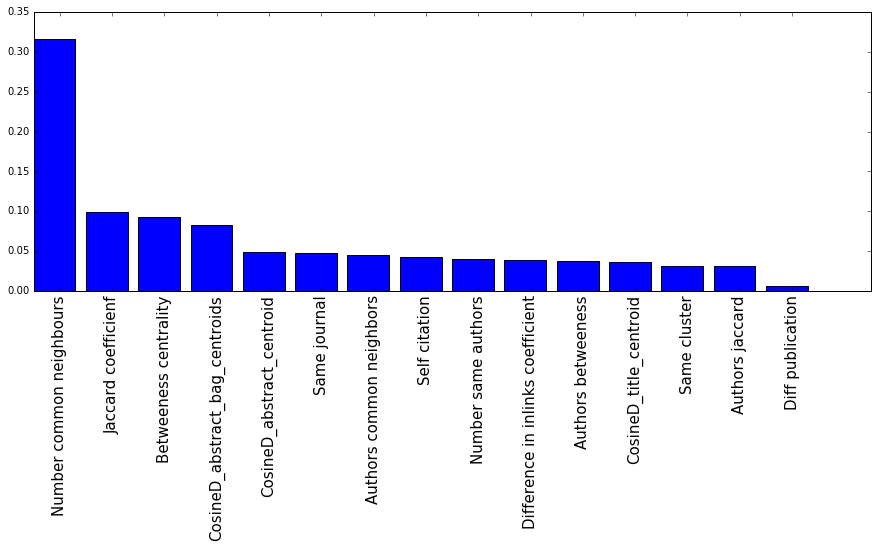

In [52]:
plt.figure(figsize=(15, 5))
X_columns = X_train_light.columns
ordering = np.argsort(gbc.feature_importances_)[::-1]

importances = gbc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

# ASSEMBLING

In [89]:
y_t = pd.read_csv("past_submits/submit7_97268.csv").values[:,1]

In [111]:
X_train.columns

Index([u'Betweeness centrality', u'Number common neighbours',
       u'Jaccard coefficienf', u'Difference in inlinks coefficient',
       u'Number of times to cited', u'Same cluster', u'CosineD_title_centroid',
       u'CosineD_abstract_centroid', u'CosineD_abstract_bag_centroids',
       u'Diff publication', u'Number same authors', u'Self citation',
       u'Same journal', u'Authors betweeness', u'Authors common neighbors',
       u'Authors jaccard', u'Authors max difference in inlinks',
       u'Authors sum difference in inlinks', u'Authors max of times to cited',
       u'Authors sum of times to cited', u'Authors  of times to cited'],
      dtype='object')

In [90]:
X_train.values.shape

(615512, 21)

In [91]:
y_t

array([0, 1, 1, ..., 0, 0, 1])

In [54]:
y_pred_array = [gbc.predict_proba(X_test_light2)[:,1], 
                clfnn1.predict_proba(X_test)[:,1].flatten(),clfnn2.predict_proba(X_test_light)[:,1].flatten(),clf.predict_proba(X_test_light2)[:,1]]

In [92]:
y_t.shape

(32648,)

In [108]:
accuracy_score(y_t,pred)

0.99568120558686601

In [55]:
def rounds(predict):
    return [0 if pr<=0.5 else 1 for pr in predict]

In [56]:
def make_pred(y_pred_array, weights = None):
    if weights ==None:
        weights = [1 for i in y_pred_array]
    return np.array(rounds(1./sum(weights)*sum([weights[i]*y for i,y in enumerate(y_pred_array)])))

In [57]:
pred = make_pred(y_pred_array)

In [60]:
accuracy_score(rounds(y_pred_array[0]),pred)

0.99568120558686601

In [61]:
def make_submission(predicted_label, name = 'submit.csv'):
    submit_d = d = {'id' : pd.Series(np.arange(predicted_label.shape[0]).astype(int)),
                    'category' : pd.Series(predicted_label).astype(int)}
    submit = pd.DataFrame(submit_d, columns=["id","category"])
    submit.to_csv(name,index=False)
    return submit


In [62]:
submit = make_submission(pred)

In [21]:
submit.shape

(32648, 2)

In [ ]:
[l for i,l in enumerate(pred)]